In [34]:
from xbbg import blp
import pdblp
import workdays
import datetime
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 70)
con = pdblp.BCon(timeout=5000)
con.start()

In [33]:
T = ["SPXT Index","ES1 Index","SBUS13L Index","SBUS13YC Index","JPY BGN Curncy"]
d_from = "20070301"
# d_from = workdays.workday(datetime.datetime.today(), days=-260).strftime("%Y%m%d")
d_to = workdays.workday(datetime.datetime.today(), days=-1).strftime("%Y%m%d")

BDH = con.bdh(T, "px_last", d_from, d_to, 
       elms = [("nonTradingDayFillOption","NON_TRADING_WEEKDAYS"),("nonTradingDayFillMethod","PREVIOUS_VALUE")] ).reset_index()

BDH = BDH[["date"]+T]
df = pd.DataFrame(BDH["date"].values,columns = ["Date"])

def ME(df):
    df["ME"] = 0
    for i in range(1,len(df)):
        if df.loc[i,"Date"].month != df.loc[i-1,"Date"].month:
            if df.loc[i-1,"Date"].month ==3:
                df.loc[i-1,"ME"] = 3
            else:
                df.loc[i-1,"ME"] = 1
    df.loc[len(df)-1,"ME"] = 3    
    return df

df = ME(df)


df["SPXT"] = BDH["SPXT Index"].pct_change()
df["JPY"] = BDH["JPY BGN Curncy"].pct_change()
df["SPXT_JPY"] = (BDH["SPXT Index"] * BDH["JPY BGN Curncy"]).pct_change()

df["ES"] = BDH["ES1 Index"].pct_change()
df["HC"] = BDH["SBUS13YC Index"].pct_change() - BDH["SBUS13L Index"].pct_change()

df["ES+JPY"] = df["ES"] - df["HC"] + df["JPY"] 


df["SPXT_JPY_Index"] = 100
df.loc[1:,"SPXT_JPY_Index"] = ( 1 + df.loc[1:,"SPXT_JPY"].values ).cumprod()*100

df["ES+JPY_Index"] = 100
df.loc[1:,"ES+JPY_Index"] = ( 1 + df.loc[1:,"ES+JPY"].values ).cumprod()*100

df["HC_Index"] = 100
df.loc[1:,"HC_Index"] = ( 1 + df.loc[1:,"HC"].values ).cumprod()*100

df

,Date,ME,SPXT,JPY,SPXT_JPY,ES,HC,ES+JPY,SPXT_JPY_Index,ES+JPY_Index,HC_Index
0,2007-03-01,0,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,100.000000,100.000000
1,2007-03-02,0,-0.011400,-0.006972,-0.018292,-0.013700,-0.000140,-0.020532,98.170784,97.946848,99.985959
2,2007-03-05,0,-0.009364,-0.010873,-0.020136,-0.009744,-0.000393,-0.020224,96.194061,95.966005,99.946619
3,2007-03-06,0,0.015536,0.009262,0.024942,0.016940,-0.000114,0.026317,98.593323,98.491496,99.935183
4,2007-03-07,0,-0.002182,-0.004631,-0.006803,-0.001611,-0.000135,-0.006108,97.922561,97.889917,99.921729
...,...,...,...,...,...,...,...,...,...,...,...
4242,2023-06-05,0,-0.001986,-0.002430,-0.004411,-0.001632,-0.000467,-0.003596,501.498015,443.210345,78.842886
4243,2023-06-06,0,0.002379,0.000358,0.002738,0.002044,-0.000158,0.002560,502.871260,444.345042,78.830426
4244,2023-06-07,0,-0.003782,0.003581,-0.000215,-0.003613,-0.000155,0.000123,502.763186,444.399733,78.818171
4245,2023-06-08,0,0.006303,-0.008635,-0.002387,0.005615,-0.000144,-0.002876,501.563256,443.121725,78.806821


In [29]:
def Ret(k):
    tmp = df.loc[df["ME"]>=k,["Date"]+[x  for x in LS]]

    for j in LS:
        tmp[j] =  tmp[j].pct_change()
    tmp = tmp.iloc[1:].reset_index(drop=True)
    tmp = tmp[["Date"]+LS]
    return tmp

def Percent(tmp):
    for i in range(0,len(tmp)):
        tmp.iloc[i,1:] = tmp.iloc[i,1:].apply("{:.1%}".format)
    return tmp

LS = ["SPXT_JPY_Index","ES+JPY_Index"]
tmp = Ret(3)
tmp["Diff"] = tmp[LS[0]] - tmp[LS[1]]
tmp  = Percent(tmp)
tmp

,Date,SPXT_JPY_Index,ES+JPY_Index,Diff
0,2008-03-31,-19.7%,-21.4%,1.7%
1,2009-03-31,-38.5%,-41.7%,3.2%
2,2010-03-31,41.5%,40.4%,1.0%
3,2011-03-31,2.9%,2.0%,0.8%
4,2012-03-30,8.2%,8.4%,-0.2%
5,2013-03-29,29.6%,28.9%,0.7%
6,2014-03-31,33.5%,32.3%,1.2%
7,2015-03-31,31.2%,30.4%,0.8%
8,2016-03-31,-4.6%,-5.3%,0.6%
9,2017-03-31,15.9%,16.2%,-0.3%


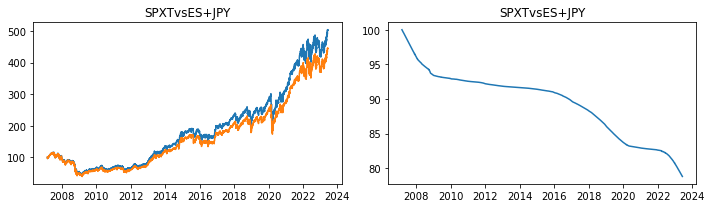

In [30]:
fig, ax = plt.subplots(1, 2, squeeze=False,figsize=(10,3),tight_layout=True)
x = df["Date"]

ax[0,0].set_title("SPXTvsES+JPY")
ax[0,0].plot(x, df["SPXT_JPY_Index"])
ax[0,0].plot(x, df["ES+JPY_Index"])

ax[0,1].set_title("SPXTvsES+JPY")
ax[0,1].plot(x, df["HC_Index"])
plt.show()